# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [233]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [4]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [5]:
#def P1(num_examples=5):
### STUDENT START ###

for index in range(5):
    print("Label: %s" %categories[train_labels[index]])
    print("\nMessage:\n\n%s\n" %train_data[index])
    
### STUDENT END ###
#P1()

Label: talk.religion.misc

Message:

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Label: sci.space

Message:



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centur

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [238]:
#def P2():
### STUDENT START ###

vectorizer = CountVectorizer()
fit_data = vectorizer.fit_transform(train_data)

# Vocabulary size is 26879
print(fit_data.shape)

# Average non-zeros = 96 (196700 / 2034)
non_zeros = fit_data.nnz
print(non_zeros / 2034.0)

# Fraction of entries that are non-zero = .0036
total_entries = 2034.0 * 26879
fraction = non_zeros/total_entries
print(fraction)

# First and last features
print(vectorizer.get_feature_names()[0])
print(vectorizer.get_feature_names()[26878])

# Specified vocabulary
vocab = ["atheism", "graphics", "space", "religion"]

vectorizer = CountVectorizer(vocabulary = vocab)
fit_data = vectorizer.fit_transform(train_data)

# Vocabulary size is now 4, which is correct
print(fit_data.shape)

# Average non-zeros now = .268; makes sense that it's smaller since it's a small subset of all words
non_zeros = fit_data.nnz
print(non_zeros / 2034.0)

# Bigrams and trigrams
ngram_sizes = (2,3)
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = ngram_sizes)
fit_data = vectorizer.fit_transform(train_data)

# Vocabulary size is 510583, including only bigrams and trigrams
print(fit_data.shape)

# Pruned features
vectorizer = CountVectorizer(min_df = 10)
fit_data = vectorizer.fit_transform(train_data)

# Vocabulary size is 3064, including only words that appear 10 or more times
print(fit_data.shape)

# Difference in vocab size between train and dev
fit_data = vectorizer.fit_transform(train_data)
train_size = fit_data.shape[1]
fit_data = vectorizer.fit_transform(dev_data)
dev_size = fit_data.shape[1]
print((train_size - dev_size) / 26879.0)

### STUDENT END ###
#P2()

(2034, 26879)
96.7059980334
0.00359782722696
00
zyxel
(2034, 4)
0.268436578171
(2034, 510583)
(2034, 3064)
0.0652554038469


ANSWER:
a) Vocabulary size is 26879, Average number of non-zero features = 96.7, fraction of non-zero = .0036
b) First feature string = "00", last = "zyxel"
c) With 4-word vocabular, average non-zero features = .268
d) Total bigram and trigram features = 510583
e) Pruned vocabulary = 3064
f) 6.5% of the words in training are missing from dev

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [239]:
#def P3():
### STUDENT START ###

vectorizer = CountVectorizer()
fit_data = vectorizer.fit_transform(train_data)
word_features = vectorizer.get_feature_names()

vectorizer_dev = CountVectorizer(vocabulary = word_features)
fit_data_dev = vectorizer_dev.fit_transform(dev_data)

# KNN
def k_predictions(neighbors):
    neighbors_model = KNeighborsClassifier(n_neighbors = neighbors)
    neighbors_model.fit(fit_data, train_labels)
    predictions = neighbors_model.predict(fit_data_dev) 
    return predictions

neighbors_model = KNeighborsClassifier()

k_values = {'n_neighbors': [1,5,10,25,100,150,200,250,500]}
k_grid = GridSearchCV(neighbors_model, k_values, scoring = 'f1_weighted')
k_grid.fit(fit_data, train_labels)

print(k_grid.grid_scores_)
print('Best K: ' + str(k_grid.best_params_))

print(classification_report(dev_labels, k_predictions(100)))

# Multinomial Naive Bayes
multi_nb = MultinomialNB()
multi_fit = multi_nb.fit(fit_data, train_labels)
alpha_values = {'alpha': [0.0, 0.0001, 0.001, 0.01, .05, .75, 0.1, 0.5, 1.0, 2.0, 10.0]}
alpha_grid = GridSearchCV(multi_nb, alpha_values, scoring = 'f1_weighted')
alpha_grid.fit(fit_data, train_labels)

print(alpha_grid.grid_scores_)
print('Best Alpha: ' + str(alpha_grid.best_params_))

multi_nb = MultinomialNB(alpha = .01)
multi_fit = multi_nb.fit(fit_data, train_labels)
print(metrics.f1_score(dev_labels, multi_fit.predict(fit_data_dev), average = 'weighted'))

# Logistic Regression
log_lm = LogisticRegression(penalty = 'l2')
c_values = {'C': [10,1,.1,.01]}
c_grid = GridSearchCV(log_lm, c_values, scoring = 'f1_weighted')
c_grid.fit(fit_data, train_labels)

print(c_grid.grid_scores_)
print('Best C: ' + str(c_grid.best_params_))

log_lm = LogisticRegression(penalty = 'l2')
log_fit = log_lm.fit(fit_data, train_labels)
print(metrics.f1_score(dev_labels, log_fit.predict(fit_data_dev), average = 'weighted'))

# Larger c-values cause a greater absolute value of the sum of the coefficients, but with diminishing (logarithmic?)
# returns as c gets larger and larger
c_values = [.01,.1,1,2,3,4,5,7,10,15,20]
for c in c_values:
    log_lm = LogisticRegression(penalty = 'l2', C = c)
    log_fit = log_lm.fit(fit_data, train_labels)
    print(str(c) + ": " + str(np.sum(log_lm.coef_)))


### STUDENT END ###
#P3()

[mean: 0.40479, std: 0.01913, params: {'n_neighbors': 1}, mean: 0.40851, std: 0.02859, params: {'n_neighbors': 5}, mean: 0.41284, std: 0.02365, params: {'n_neighbors': 10}, mean: 0.40425, std: 0.00905, params: {'n_neighbors': 25}, mean: 0.41963, std: 0.00661, params: {'n_neighbors': 100}, mean: 0.40970, std: 0.00967, params: {'n_neighbors': 150}, mean: 0.39182, std: 0.01965, params: {'n_neighbors': 200}, mean: 0.36106, std: 0.01486, params: {'n_neighbors': 250}, mean: 0.27165, std: 0.00930, params: {'n_neighbors': 500}]
Best K: {'n_neighbors': 100}
             precision    recall  f1-score   support

          0       0.47      0.33      0.38       165
          1       0.48      0.58      0.52       185
          2       0.48      0.57      0.52       199
          3       0.32      0.24      0.28       127

avg / total       0.44      0.45      0.44       676

[mean: 0.23391, std: 0.01242, params: {'alpha': 0.0}, mean: 0.82552, std: 0.00599, params: {'alpha': 0.0001}, mean: 0.82619,

ANSWER:
a) KNN doesn't work as well here, because our data is high-dimensional (~27k) and KNN is capturing all that variance and likely overfitting. This idea seems confirmed by the fact that the grid search returns a high value of K (K=100) as the best performing.  
b) I actually would have expected logistic regression to outperform NB, because of NB's independence assumption and the fact that the likelihood of one word's appearance depends on another. But since is the not the case, I'd guess that NB's high bias is advantage here and that the logistic regression model is overfitting somewhat.
c) Larger c-values cause a greater absolute value of the sum of the coefficients, but with diminishing (logarithmic?) returns as c gets larger and larger

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [241]:
#def P4():
### STUDENT START ###

# Logistic Regression

log_lm = LogisticRegression(penalty = 'l2', C = 3)
log_fit = log_lm.fit(fit_data, train_labels)

# Stack columns of coefficients for each class along with the feature in a single matrix
word_features = np.array(vectorizer.get_feature_names())
weights = np.array(log_lm.coef_)
feature_weights = np.column_stack((word_features,
                                   weights[0].astype('float'),
                                   weights[1].astype('float'),
                                   weights[2].astype('float'),
                                   weights[3].astype('float')))

# Take the index of the 5 largest coefficients for each class
feature_0_weights = weights[0].argsort()[-5:][::-1]
feature_1_weights = weights[1].argsort()[-5:][::-1]
feature_2_weights = weights[2].argsort()[-5:][::-1]
feature_3_weights = weights[3].argsort()[-5:][::-1]

# Combine into single matrix with 20 rows
final_matrix = np.vstack((feature_weights[feature_0_weights],
               feature_weights[feature_1_weights],
               feature_weights[feature_2_weights],
               feature_weights[feature_3_weights]))

# Output tables

print'      alt.atheism  comp.graphics  sci.space    religion.misc  '
for word, w0, w1, w2, w3 in final_matrix:
    print "%s | %1f | %2f | %2f | %2f" %(word.encode('utf-8'), 
                                         float(w0.encode('utf-8')),
                                         float(w1.encode('utf-8')),
                                         float(w2.encode('utf-8')),
                                         float(w3.encode('utf-8')))

# Bigrams
bigram_features = vectorizer.get_feature_names()
ngram_sizes = (2,2)
vectorizer_train = CountVectorizer(analyzer = 'word', ngram_range = ngram_sizes)
bigram_data_train = vectorizer_train.fit_transform(train_data)

bigram_features = vectorizer_train.get_feature_names()

vectorizer_dev = CountVectorizer(analyzer = 'word', ngram_range = ngram_sizes, vocabulary = bigram_features)
bigram_data_dev = vectorizer_dev.fit_transform(dev_data)

log_lm = LogisticRegression(penalty = 'l2', C = 3)
log_fit = log_lm.fit(bigram_data_train, train_labels)

weights = np.array(log_lm.coef_)
feature_weights = np.column_stack((bigram_features,
                                   weights[0].astype('float'),
                                   weights[1].astype('float'),
                                   weights[2],
                                   weights[3]))
feature_0_weights = weights[0].argsort()[-5:][::-1]
feature_1_weights = weights[1].argsort()[-5:][::-1]
feature_2_weights = weights[2].argsort()[-5:][::-1]
feature_3_weights = weights[3].argsort()[-5:][::-1]
final_matrix = np.vstack((feature_weights[feature_0_weights],
               feature_weights[feature_1_weights],
               feature_weights[feature_2_weights],
               feature_weights[feature_3_weights]))

print'              alt.atheism  comp.graphics  sci.space    religion.misc  '
for word, w0, w1, w2, w3 in final_matrix:
    print "%s | %1f | %2f | %2f | %2f" %(word.encode('utf-8'), 
                                         float(w0.encode('utf-8')),
                                         float(w1.encode('utf-8')),
                                         float(w2.encode('utf-8')),
                                         float(w3.encode('utf-8')))
    
print(feature_1_weights)

### STUDENT END ###
#P4()

      alt.atheism  comp.graphics  sci.space    religion.misc  
deletion | 2.023079 | -0.790562 | -0.802547 | -0.735433
atheists | 1.371638 | -0.101847 | -0.408057 | -1.185509
bobby | 1.274112 | -0.267410 | -0.423051 | -0.594631
religion | 1.226714 | -0.807707 | -1.029083 | -0.064206
loans | 1.194982 | -0.218116 | -0.427503 | -0.409550
graphics | -0.969694 | 2.479035 | -1.742518 | -1.017615
image | -0.788835 | 1.727804 | -1.088816 | -0.632669
file | -0.456291 | 1.609718 | -1.015865 | -0.857205
3d | -0.447318 | 1.430195 | -0.928243 | -0.478108
keywords | -0.490888 | 1.360314 | -0.504014 | -0.442089
space | -1.599621 | -1.652857 | 2.680298 | -1.521070
orbit | -0.520017 | -0.862631 | 1.593271 | -0.853705
nasa | -0.763056 | -0.590309 | 1.293998 | -0.575702
spacecraft | -0.453596 | -0.520951 | 1.229926 | -0.548275
launch | -0.639581 | -0.578342 | 1.196177 | -0.416001
christians | -0.967143 | -0.597575 | -0.764432 | 1.506337
christian | -0.837684 | -0.566856 | -0.329025 | 1.438227
blood | -0.

ANSWER: All of the religion bigrams seem pretty strange. Not quite sure what is going on here - maybe some kind of overfitting where a single poster in that forum is posting repeatedly about some off topic things. The compuserve.com feature is maybe the result of spam.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [243]:
#def empty_preprocessor(s):
#    return s

def preprocess(words):
#     return words
    lower = words.lower()
#     #return lower
    lower = re.sub(r"[^\w\s] "," ", lower)
    lower = re.sub("ies ", "y ", lower)
#     lower = re.sub(" are ", " be ", lower)
#     lower = re.sub(" is ", " be ", lower)
#     lower = re.sub(" am ", " be ", lower)
#     lower = re.sub(" was ", " be ", lower)
#     lower = re.sub(" were ", " be ", lower)
    lower = re.sub(r"[0-9][0-9]*","xNUMBERx", lower)
#     lower = re.sub("s ", " ", lower)
#     lower = re.sub("tion ", "te ", lower)
    return(lower)


vectorizer = CountVectorizer(preprocessor = preprocess)
fit_data = vectorizer.fit_transform(train_data)
word_features = vectorizer.get_feature_names()

vectorizer_dev = CountVectorizer(vocabulary = word_features)
fit_data_dev = vectorizer_dev.fit_transform(dev_data)
log_lm = LogisticRegression(penalty = 'l2')
log_fit = log_lm.fit(fit_data, train_labels)
print(26879 - len(word_features))
print(metrics.f1_score(dev_labels, log_fit.predict(fit_data_dev), average = 'weighted'))
print(classification_report(dev_labels, log_fit.predict(fit_data_dev)))


#def better_preprocessor(s):

### STUDENT START ###

### STUDENT END ###

#def P5():
### STUDENT START ###

### STUDENT END ###
#P5()

2199
0.701332289297
             precision    recall  f1-score   support

          0       0.62      0.56      0.59       165
          1       0.81      0.85      0.83       185
          2       0.74      0.80      0.77       199
          3       0.58      0.53      0.55       127

avg / total       0.70      0.71      0.70       676



ANSWER:
The vocabulary was reduced by 2199

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

44928
[0.69230769230769229, 0.67899408284023666, 0.68195266272189348, 0.69526627218934911, 0.69526627218934911, 0.69526627218934911, 0.69230769230769229, 0.7026627218934911, 0.68639053254437865, 0.67011834319526631, 0.67603550295857984, 0.68934911242603547, 0.62573964497041423, 0.47189349112426038]
[2108, 1651, 895, 815, 750, 665, 634, 565, 486, 411, 294, 172, 94, 10]


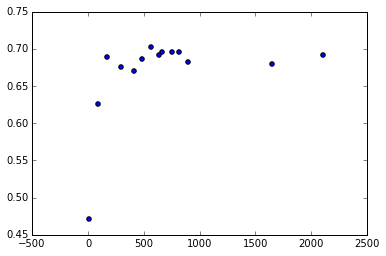

In [186]:
#def P6():
# Keep this random seed here to make comparison easier.
np.random.seed(0)

### STUDENT START ###

vectorizer = CountVectorizer()
fit_data = vectorizer.fit_transform(train_data)
word_features = vectorizer.get_feature_names()

vectorizer_dev = CountVectorizer(vocabulary = word_features)
fit_data_dev = vectorizer_dev.fit_transform(dev_data)

# L2 Model
log_lm = LogisticRegression(penalty = 'l2')
log_fit = log_lm.fit(fit_data, train_labels)
weights = np.array(log_lm.coef_)
non_zero = weights[weights > 0]
print(len(non_zero))
#print(log_lm.score(fit_data_dev, dev_labels))


c_values = [10,5,1,.9,.8,.7,.6,.5,.4,.3,.2,.1,.05,.01]
accuracies = []
vocab_sizes = []

for value in c_values:
    # L1 Model
    log_lm = LogisticRegression(penalty = 'l1', C = value, tol = .01)
    log_fit = log_lm.fit(fit_data, train_labels)

    # Find non-zero weights in L1 model
    weights = np.array(log_lm.coef_)
    non_zero = weights > abs(0)
    non_zero_vector = np.where(np.sum(non_zero, 0))[0]
    # Number of non-zero weights = 739

    # Assemble new vocabulary including only non-zero weights
    word_features = vectorizer.get_feature_names()
    new_vocab = [word_features[x] for x in non_zero_vector]
    vocab_sizes.append(len(new_vocab))

    # L2 Model with shrunk vocabulary
    vectorizer = CountVectorizer(vocabulary = new_vocab)
    fit_data = vectorizer.fit_transform(train_data)

    log_lm = LogisticRegression(penalty = 'l2', C = value, tol = .01)
    log_fit = log_lm.fit(fit_data, train_labels)
    
    vectorizer_dev = CountVectorizer(vocabulary = new_vocab)
    fit_data_dev = vectorizer_dev.fit_transform(dev_data)
    
    accu = log_lm.score(fit_data_dev, dev_labels)
    accuracies.append(accu)

print(accuracies)
print(vocab_sizes)
plt.scatter(vocab_sizes, accuracies)


### STUDENT END ###
#P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [232]:
#def P7():
### STUDENT START ###
vectorizer = TfidfVectorizer()
fit_data = vectorizer.fit_transform(train_data)
word_features = vectorizer.get_feature_names()

vectorizer_dev = TfidfVectorizer(vocabulary = word_features)
fit_data_dev = vectorizer_dev.fit_transform(dev_data)

log_lm = LogisticRegression(C = 100)
log_fit = log_lm.fit(fit_data, train_labels)
probs = log_lm.predict_proba(fit_data_dev)
print(probs.shape)

# Calculate R for each observation
r_values = []
for index, prob in enumerate(probs):
    correct_label = dev_labels[index]
    correct_prob = prob[correct_label]
    max_prob = np.amax(prob)
    r = max_prob / correct_prob
    r_values.append(r)

# Check accuracy
r_values = np.array(r_values)
count_ones = np.where(r_values == 1.0)

# Should be the same
print(float(len(count_ones[0])) / len(r_values))
print(log_lm.score(fit_data_dev, dev_labels))

# Find max R
max_r = r_values.argsort()[-3:][::-1]
print(max_r)

# Print docs
docs = [dev_data[x]for x in max_r]
for index, doc in enumerate(docs):
    print(index)
    print(doc)
    
## STUDENT END ###
#P7()

(676, 4)
0.760355029586
0.760355029586
[215 607 665]
0
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book. See the permissions not

ANSWER:
TFIDF is different because it not only counts how frequently a word appears in an observation, but also how frequently it appears in all of the data. It then weights the importance of each word by the inverse of it's total frequencey, so a word that appears more frequently across all the data is less important than one that is rare.

It seems like the mistakes are being made on very large and very small examples, i.e. those with lots of words or very few words. The problem with the long observations might be that a long post is more likely to have rare words (and more of them) due soley to it's length, and so the model is overconfident in its prediction. Maybe taking a sample/subset of the long posts, or even just truncating them, would help to prevent this.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.